# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

homeo_method = 'HEH'
tag = 'autoencoder'
# tag = 'independance'

matname = tag +'_' + homeo_method

nb_quant = 128
nb_quant = 256
C = 5.
eta_homeo=0.05
alpha_homeo=0.02
do_double_shuffle = True
do_double_shuffle = False
do_random = True

n_iter = 2**13 + 1

record_num_batches = 2**11
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            homeo_method=homeo_method, eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)


In [4]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname=tag)

Extracting data..loading the data called : data_cache/autoencoder_data
Data is of shape : (81920, 144) - done in 0.31s.


In [5]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 lolo  staff   2533678 Feb 19 18:58 data_cache/autoencoder_HEH_dico.pkl
-rw-r--r--  1 lolo  staff   1450227 Feb 19 19:35 data_cache/autoencoder_None_dico.pkl
-rw-r--r--  1 lolo  staff  94371968 Feb 19 16:18 data_cache/autoencoder_data.npy


In [6]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 144)
average of patches =  1.274788766001906e-05  +/-  0.008208904871778732
average energy of data =  0.05934010035972646 +/- 0.06825018408240678


In [7]:
l0_sparseness = shl.l0_sparseness
l0_sparseness_noise = 200 #shl.n_dictionary #
#l0_sparseness_high = shl.l0_sparseness * 2
shl.do_precision

False

In [8]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

loading the dico called : data_cache/autoencoder_HEH_dico.pkl


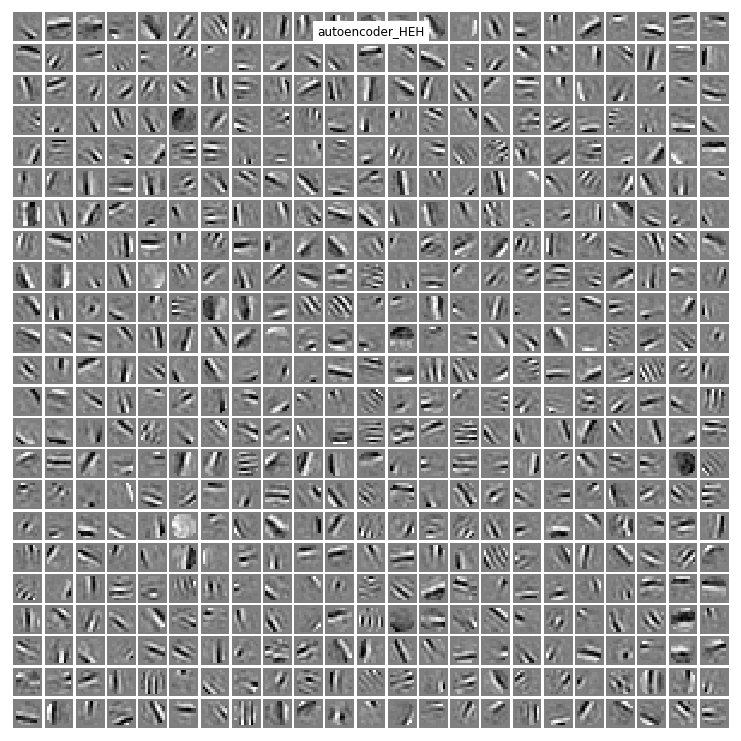

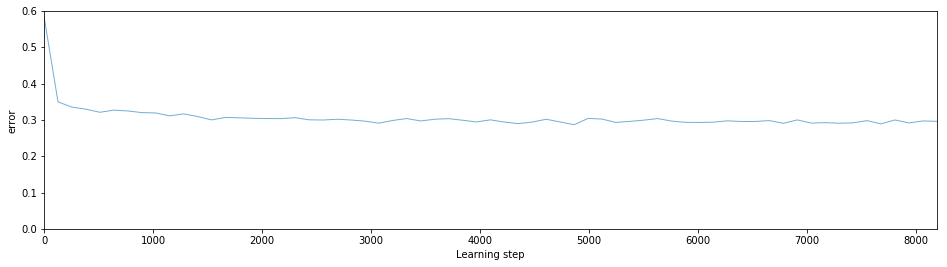

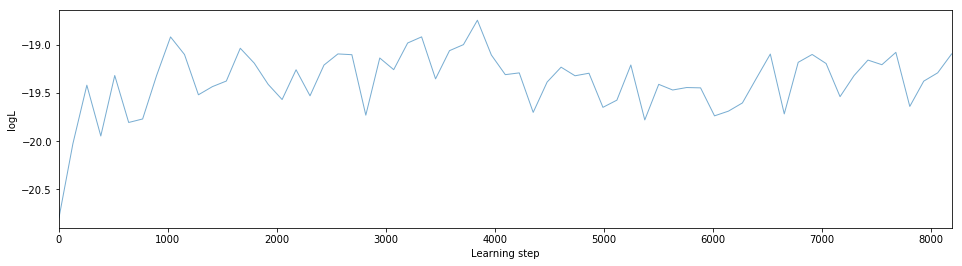

In [9]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL']

dico_homeo = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico_homeo.dictionary.shape)
print('average of filters = ',  dico_homeo.dictionary.mean(axis=1).mean(), 
      '+/-',  dico_homeo.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico_homeo.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  7.475646834982161e-05 +/- 0.0088696166268131
average energy of filters =  1.0 +/- 8.106006505517214e-17


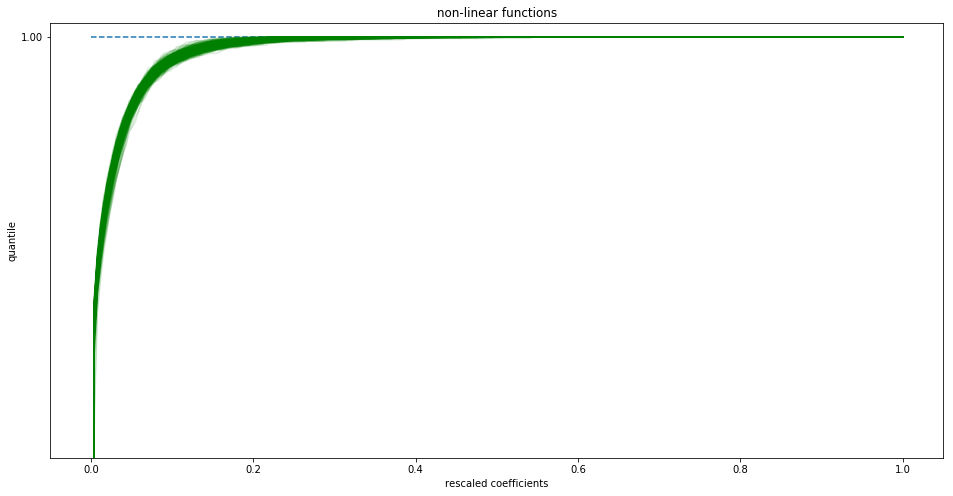

In [11]:
if not dico_homeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_homeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.97, 1.001)
    #ax.set_xmargin(0.);

## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [12]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')
    patches = sparse_code @ dictionary
    error = data - patches

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    print('number of codes, size of reconstructed images = ', patches.shape)

    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    #print('average gain of coding = ', data[indx, :].std()/error.std())  
    
    return SD, SE

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004003209791042877
average std of codewords =  0.04421267625048541
l0-sparseness of codewords =  0.028309236176748583  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.001065434713007099
number of codes, size of reconstructed images =  (2048, 144)


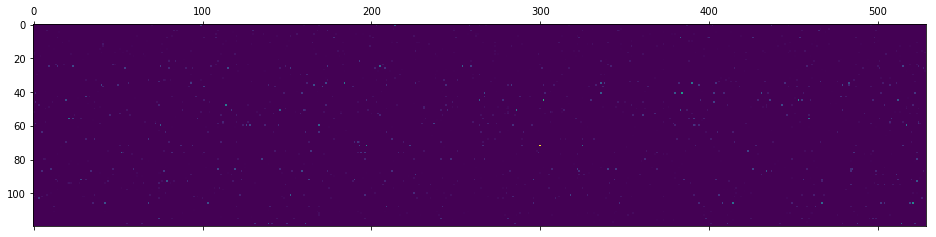

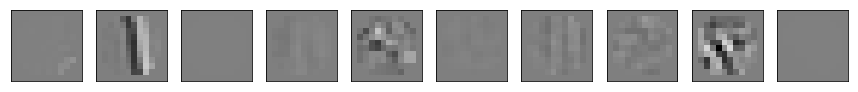

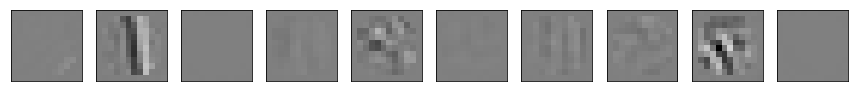

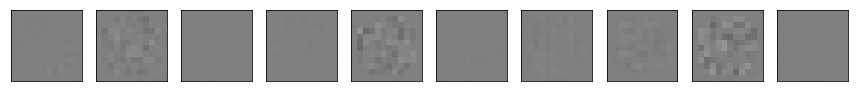

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -1.249279638298771e-05 +/- 0.002177763634785077
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.016584235265907493 +/- 0.019142633255778543
median energy of residual =  0.008983247327314316
average gain of coding =  3.855142282565051 +/- 1.3795677839060247
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004003209791042877
average std of codewords =  0.04421267625048541
l0-sparseness of codewords =  0.028309236176748583  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0010654347130070988
number of codes, size of reconstructed images =  (2048, 144)


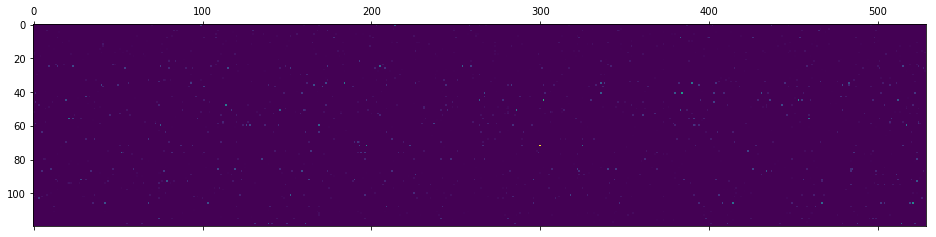

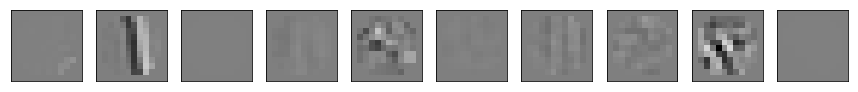

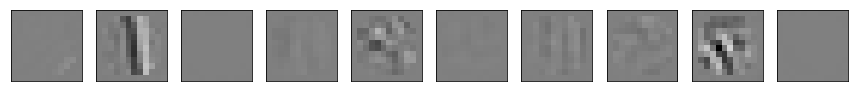

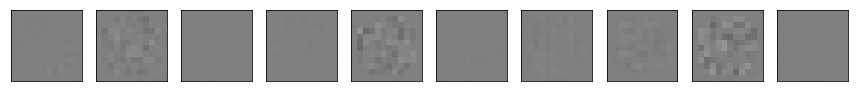

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -1.2492796382987591e-05 +/- 0.002177763634785077
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.016584235265907493 +/- 0.01914263325577854
median energy of residual =  0.008983247327314318
average gain of coding =  3.855142282565051 +/- 1.3795677839060245
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004018365298152866
average std of codewords =  0.04409568141986469
l0-sparseness of codewords =  0.028302774988185255  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0011676774812821237
number of codes, size of reconstructed images =  (2048, 144)


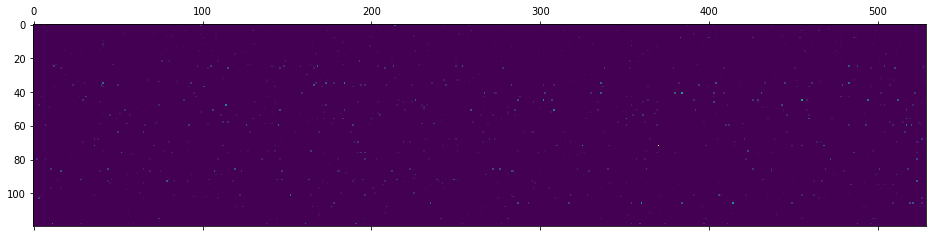

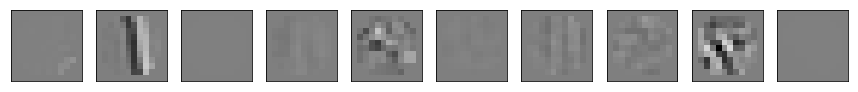

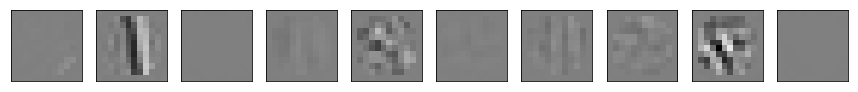

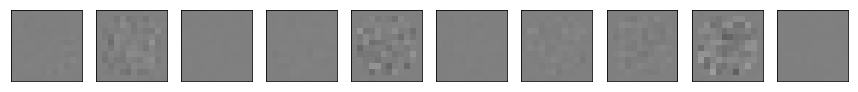

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -0.00011419844953841613 +/- 0.002493669622592824
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.01715142367950196 +/- 0.01988402918488138
median energy of residual =  0.009250120321560754
average gain of coding =  3.763316070290095 +/- 1.400952989499675


In [13]:
from shl_scripts.shl_encode import sparse_encode
if dico_homeo.P_cum is None: 
    gain = np.ones(shl.n_dictionary)
else:
    gain = None
dico_rec = dico_homeo.dictionary

for P_cum_rec, gain_rec in zip([None, P_cum_zeroeffect, dico_homeo.P_cum], [np.ones(shl.n_dictionary), None, gain]):
    sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

    SD, SE = print_stats(data[indx, :], dico_homeo.dictionary, sparse_code)

## Generating new coefficients by shuffling and decoding

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [ 54  45  42  26  40  74  72  41  43  42  86  39  46  54  80  35  47  57
  73  43  43  40  53  65  55  42  50  33  72  48  49  71  43  48  25  46
  46  63  99  66  32  85  75  33  75  48  53  38  48  55  83  49  29  52
  50  57  55  68  32  61  66  41  54  61  59  70  44  49  55 129  60  78
  62  62 159  49  62  61  58  48  54  29  43  61 121  53  58  

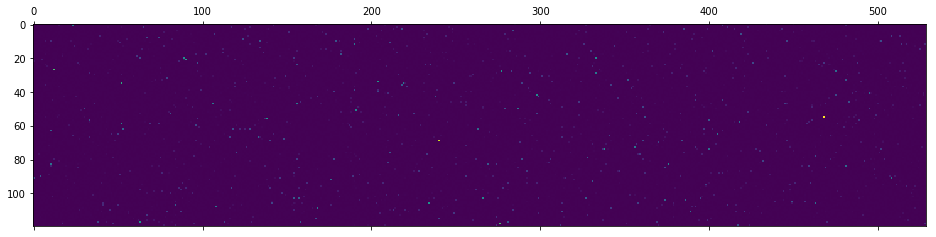

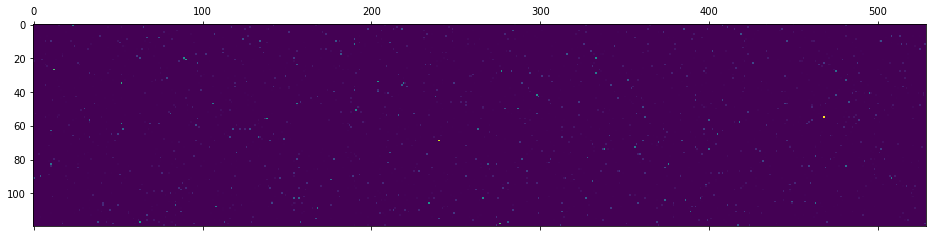

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [57 60 73 58 56 45 41 61 62 59 59 48 56 63 62 56 66 56 35 63 49 65 46 56
 55 52 62 55 56 72 56 49 53 67 68 73 59 61 71 52 62 58 54 69 62 64 65 51
 54 59 60 41 54 59 62 67 56 41 52 72 43 48 57 63 59 54 53 51 54 56 55 55
 65 52 55 52 65 50 66 65 68 69 51 53 67 43 68 55 65 56 61 48 58 59 58 53
 55 59 69 49 50 55 67 58 55 49 62 52 54 45 58 50 62 72 46 46 5

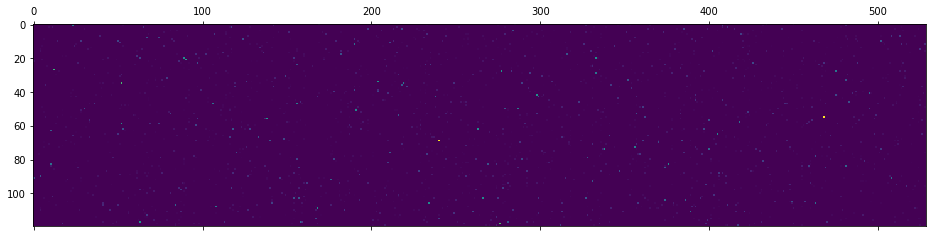

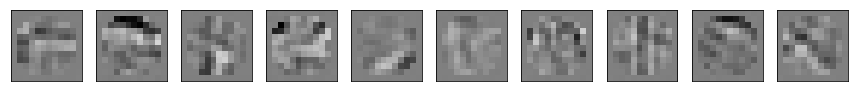

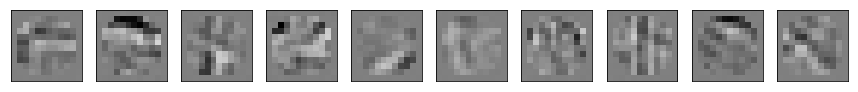

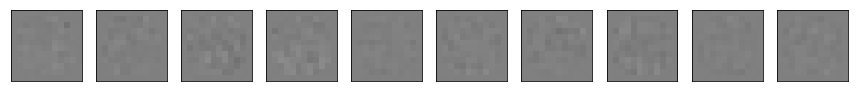

average of data patches =  0.0005004223214475975 +/- 0.00842266617774756
average of residual patches =  -6.420863508195683e-06 +/- 0.0013061438116460688
median energy of data =  0.06957154863081992
average energy of data =  0.07710137545921494 +/- 0.03786840007381954
average energy of residual =  0.008756369856929378 +/- 0.004131881099328979
median energy of residual =  0.007710099711514693
average gain of coding =  9.35646323183315 +/- 4.488342911158118


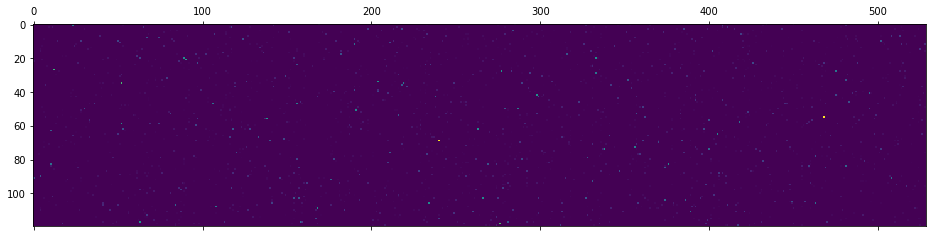

mean deviation of coefficients =  0.013800398479721027 0.004330092747960465 0.0043475916939187415
total deviation of coefficients =  0.0025401115981326956
mean deviation of quantiles =  0.007214222235606799
mean deviation of quantiles =  0.00712329846868665
total deviation of quantiles =  0.008706912071784959
ratio deviation of quantiles =  1.2069093226447587
proba incorrect coefficients =  0.9720452061672968
proba incorrect coefficients (strong) =  0.034412290288279745


In [14]:
def shuffling(data, sparse_code, dico):
    if do_random:
        from shl_scripts.shl_encode import inv_quantile, inv_rescaling
        sparse_code_bar = inv_rescaling(inv_quantile(dico.P_cum, np.random.rand(sparse_code.shape[0], sparse_code.shape[1])), C=C)
    else:
        sparse_code = sparse_encode(data, dico.dictionary, P_cum=dico.P_cum, C=C, 
                                     l0_sparseness=l0_sparseness_noise, gain=None)   

        sparse_code_bar = sparse_code.copy()
        
        sparse_code_bar = sparse_code_bar.T
        np.random.shuffle(sparse_code_bar)
        sparse_code_bar = sparse_code_bar.T
        
        if do_double_shuffle:
            np.random.shuffle(sparse_code_bar)


    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code, axis=0)[:N_show])

    print(sparse_code_bar.shape)

    plt.matshow(sparse_code_bar[:N_show, :])
    plt.show()

    def threshold(sparse_code, l0_sparseness):
        thr = np.percentile(sparse_code, 100 * (1 - l0_sparseness/shl.n_dictionary ), axis=1)
        return (sparse_code>thr[:, np.newaxis])

    sparse_code_bar_high = threshold(sparse_code_bar, l0_sparseness) * sparse_code_bar
    plt.matshow(sparse_code_bar_high[:N_show, :])
    plt.show()
    return sparse_code_bar, sparse_code_bar_high

def pipeline(sparse_code_bar, sparse_code_bar_high, dico, index):

    patches_bar = sparse_code_bar @ dico.dictionary
    SD = np.sqrt(np.mean(patches_bar**2, axis=1))


    P_cum_rec = dico.P_cum
    if P_cum_rec is None: 
        gain_rec = np.ones(shl.n_dictionary)
    else:
        gain_rec = None

    sparse_code_rec = sparse_encode(patches_bar, dico.dictionary, P_cum=P_cum_rec, C=C, 
                                     l0_sparseness=l0_sparseness, gain=gain_rec)   

    print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_bar_high, axis=0)[:N_show])
    print('average non-zeros', np.count_nonzero(sparse_code_rec, axis=0)[:N_show])
    
    
    SD, SE = print_stats(patches_bar, dico.dictionary, sparse_code_rec)
    
    plt.matshow(sparse_code_rec[:N_show, :])
    plt.show()

    print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_bar)), np.mean(np.abs(sparse_code_bar_high)), np.mean(np.abs(sparse_code_rec)))
    print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar_high-sparse_code_rec)))

    if not dico.P_cum is None: 
        from shl_scripts.shl_encode import quantile, rescaling

        q_rec = quantile(dico.P_cum, rescaling(sparse_code_rec, C=C), stick, do_fast=False)
        q_bar = quantile(dico.P_cum, rescaling(sparse_code_bar_high, C=C), stick, do_fast=False)

        print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
        print('mean deviation of quantiles = ', np.mean(np.abs(q_rec)))
        print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))
        print('ratio deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar)))
        aerror = np.mean(np.abs(q_bar-q_rec))/np.mean(np.abs(q_bar))
    else:
        aerror = np.nan

    perror = 1 - np.mean( (sparse_code_bar>0) == (sparse_code_rec>0))
    print('proba incorrect coefficients = ', perror)

    perror_high = 1 - np.mean( (sparse_code_bar_high > 0) == (sparse_code_rec>0))
    print('proba incorrect coefficients (strong) = ', perror_high)
    
    return pd.DataFrame({'error':[(SD/SE).mean()],
                               'aerror':[aerror],
                               'perror':[perror],
                               'perror_high':[perror_high]
                                        },
                                index=[index])

sparse_code_bar, sparse_code_bar_high = shuffling(data[indx, :], sparse_code, dico_homeo)
record = pipeline(sparse_code_bar, sparse_code_bar_high, dico_homeo, index='homeo')

In [15]:
record

,aerror,error,perror,perror_high
homeo,1.206909,9.356463,0.972045,0.034412


## comparing to the learning without homeostasis

Extracting data..loading the data called : data_cache/autoencoder_data
Data is of shape : (81920, 144) - done in 0.21s.
loading the dico called : data_cache/autoencoder_None_dico.pkl


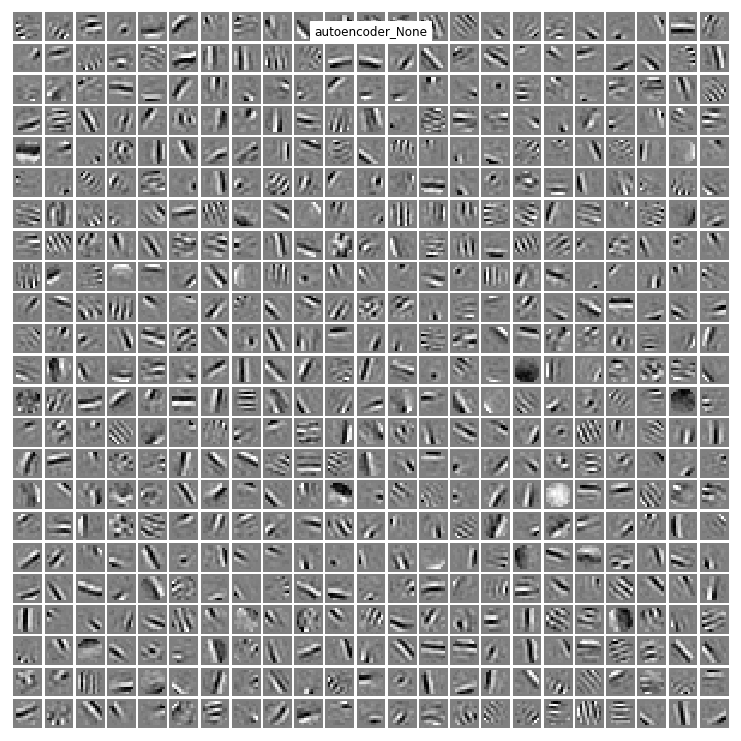

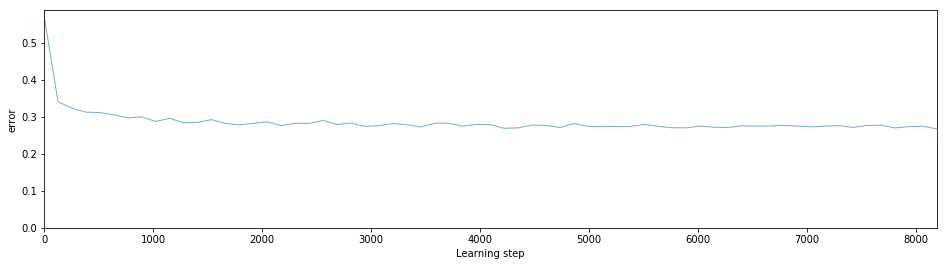

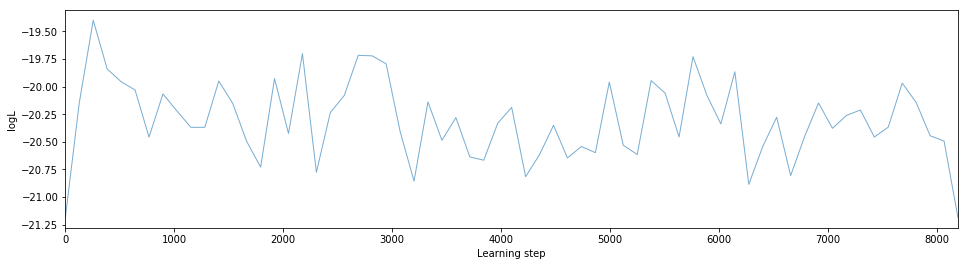

In [16]:
homeo_method = 'None'
matname = tag + '_' + homeo_method

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            homeo_method=homeo_method, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl_nohomeo = SHL(**opts)
data = shl_nohomeo.get_data(matname=tag)
dico_nohomeo = shl_nohomeo.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [17]:
if not dico_nohomeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_nohomeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.85, 1.01)
    #ax.set_xmargin(0.);

### coding


🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 529)
average of codewords =  0.004015823502618079
average std of codewords =  0.04439931469859247
l0-sparseness of codewords =  0.02831477433837429  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0012427062681240274
number of codes, size of reconstructed images =  (2048, 144)


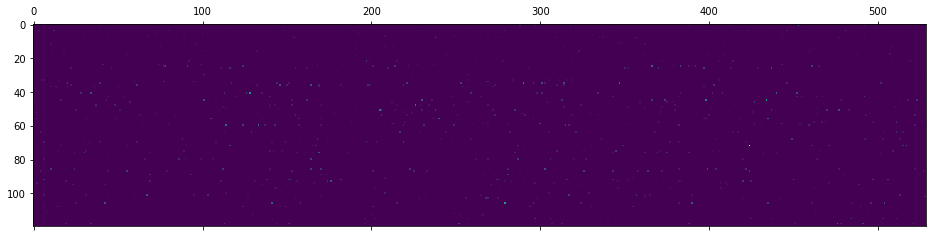

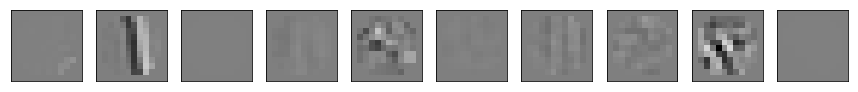

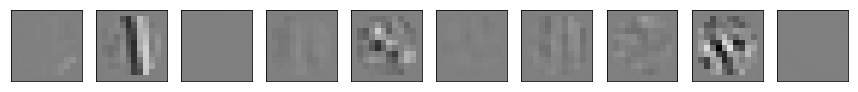

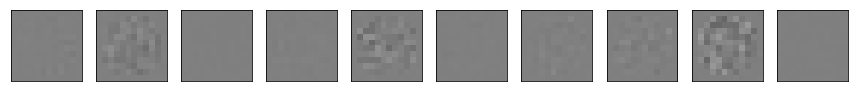

average of data patches =  8.645923389323598e-05 +/- 0.007589220242732098
average of residual patches =  -5.8061367464829336e-05 +/- 0.002297440669798243
median energy of data =  0.028980042378636613
average energy of data =  0.05700159151318996 +/- 0.06799758198001712
average energy of residual =  0.016010318457487318 +/- 0.01835005390643144
median energy of residual =  0.008608995074089736
average gain of coding =  4.09948044102892 +/- 1.6931225014154176


(array([0.0084, 0.089 , 0.0004, ..., 0.0885, 0.0498, 0.0008]),
 array([0.0031, 0.015 , 0.    , ..., 0.0232, 0.013 , 0.0002]))

In [18]:
P_cum_rec = None 
gain_rec = np.ones(shl_nohomeo.n_dictionary)
dico_rec = dico_nohomeo.dictionary

sparse_code = sparse_encode(data[indx, :], dico_rec, P_cum=P_cum_rec, C=C, 
                                 l0_sparseness=l0_sparseness, gain=gain_rec)   

print_stats(data[indx, :], dico_nohomeo.dictionary, sparse_code)

### Generating and shuffling the coefficients

average non-zeros [2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048 2048
 2048 2048 2048 2048 2048 2048 2048 2048]
average non-zeros [57 60 73 58 56 45 41 61 62 59 59 48 56 63 62 56 66 56 35 63 49 65 46 56
 55 52 62 55 56 72 56 49 53 67 68 73 59 61 71 52 62 58 54 69 62 64 65 51
 54 59 60 41 54 59 62 67 56 41 52 72 43 48 57 63 59 54 53 51 54 56 55 55
 65 52 55 52 65 50 66 65 68 69 51 53 67 43 68 55 65 56 61 48 58 59 58 53
 55 59 69 49 50 55 67 58 55 49 62 52 54 45 58 50 62 72 46 46 5

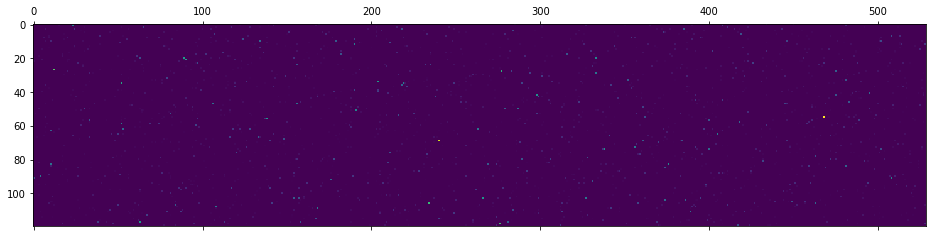

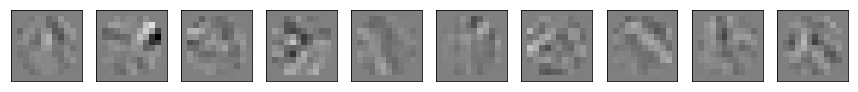

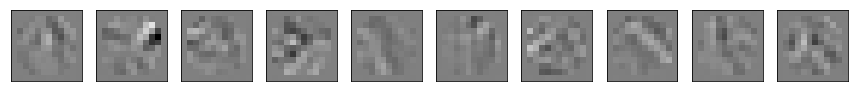

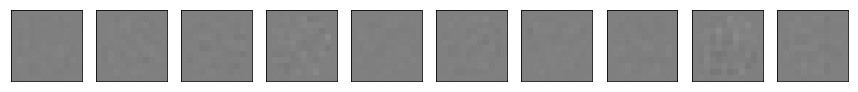

average of data patches =  0.0011751533077084331 +/- 0.008752481256375138
average of residual patches =  0.00025408005986110057 +/- 0.0009211808591866711
median energy of data =  0.06960284369759562
average energy of data =  0.07756877926218145 +/- 0.0383430928305101
average energy of residual =  0.008028361009870682 +/- 0.0031797538593957768
median energy of residual =  0.007185975099931242
average gain of coding =  10.098183209236687 +/- 4.782049075539132


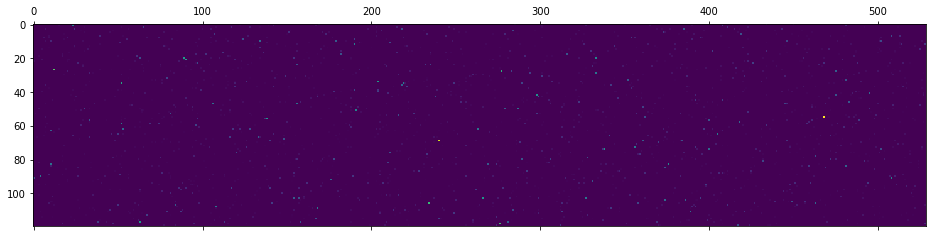

mean deviation of coefficients =  0.013800398479721027 0.004330092747960465 0.004351879674661069
total deviation of coefficients =  0.002221877765885517
proba incorrect coefficients =  0.9721033568643668
proba incorrect coefficients (strong) =  0.032618848948487766


,aerror,error,perror,perror_high
homeo,1.206909,9.356463,0.972045,0.034412
nohomeo,NaN,10.098183,0.972103,0.032619


In [19]:
pd.concat([record, pipeline(sparse_code_bar, sparse_code_bar_high, dico_nohomeo, index='nohomeo')])

## Version used

In [20]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
pandas 0.22.0
Wed Feb 21 16:21:00 2018 CET